In [1]:
# Import library yang diperlukan
import numpy as np
import pandas as pd

# Fungsi untuk menampilkan hasil setiap tahap
def print_step(title, data):
    print(f"\n=== {title} ===")
    print(data)

# --- Tahap 1: Pengguna Memasukkan Kebutuhan Spesifikasi Laptop ---
# Simulasi preferensi pengguna (contoh: prioritas tinggi pada RAM dan harga rendah)
user_preferences = {
    'Processor': 0.2,  # Bobot untuk prosesor
    'RAM': 0.4,       # Bobot untuk RAM (prioritas tinggi)
    'Storage': 0.1,   # Bobot untuk penyimpanan
    'Price': 0.3      # Bobot untuk harga (prioritas rendah = harga murah lebih baik)
}
print_step("Input Preferensi Pengguna", user_preferences)

# Data dummy laptop (5 alternatif dengan 4 kriteria)
laptops = pd.DataFrame({
    'Laptop': ['Laptop A', 'Laptop B', 'Laptop C', 'Laptop D', 'Laptop E'],
    'Processor': [8, 6, 10, 7, 9],    # Skor prosesor (1-10)
    'RAM': [16, 8, 32, 16, 4],        # Kapasitas RAM (GB)
    'Storage': [512, 256, 1000, 512, 128],  # Kapasitas penyimpanan (GB)
    'Price': [10000, 8000, 15000, 12000, 6000]  # Harga (ribu rupiah)
})
print_step("Data Laptop Awal", laptops)


=== Input Preferensi Pengguna ===
{'Processor': 0.2, 'RAM': 0.4, 'Storage': 0.1, 'Price': 0.3}

=== Data Laptop Awal ===
     Laptop  Processor  RAM  Storage  Price
0  Laptop A          8   16      512  10000
1  Laptop B          6    8      256   8000
2  Laptop C         10   32     1000  15000
3  Laptop D          7   16      512  12000
4  Laptop E          9    4      128   6000


In [2]:
# --- Tahap 2: Melakukan Pembobotan Input Spesifikasi ---
# Normalisasi data (benefit: Processor, RAM, Storage; cost: Price)
normalized = laptops.copy()
for col in ['Processor', 'RAM', 'Storage']:
    normalized[col] = laptops[col] / laptops[col].max()  # Benefit criteria
normalized['Price'] = laptops['Price'].min() / laptops['Price']  # Cost criteria
print_step("Matriks Normalisasi", normalized.drop('Laptop', axis=1))


=== Matriks Normalisasi ===
   Processor    RAM  Storage  Price
0        0.8  0.500    0.512   0.60
1        0.6  0.250    0.256   0.75
2        1.0  1.000    1.000   0.40
3        0.7  0.500    0.512   0.50
4        0.9  0.125    0.128   1.00


In [3]:
# --- Tahap 3: Hitung Penilaian dengan Fuzzy SAW ---
# Fungsi keanggotaan Fuzzy sederhana (contoh: segitiga)
def fuzzy_membership(value, a, b, c):
    if value <= a:
        return 0
    elif a < value <= b:
        return (value - a) / (b - a)
    elif b < value <= c:
        return (c - value) / (c - b)
    else:
        return 0

# Terapkan Fuzzy SAW
fuzzy_scores = []
for i, row in normalized.iterrows():
    score = 0
    for crit, weight in user_preferences.items():
        # Simulasi nilai Fuzzy (a=0, b=0.5, c=1)
        fuzzy_val = fuzzy_membership(row[crit], 0, 0.5, 1)
        # Defuzzifikasi sederhana: ambil nilai tengah
        crisp_val = fuzzy_val * weight
        score += crisp_val
    fuzzy_scores.append(score)

laptops['Fuzzy_SAW_Score'] = fuzzy_scores
print_step("Skor Fuzzy SAW", laptops[['Laptop', 'Fuzzy_SAW_Score']])


=== Skor Fuzzy SAW ===
     Laptop  Fuzzy_SAW_Score
0  Laptop A           0.8176
1  Laptop B           0.5612
2  Laptop C           0.2400
3  Laptop D           0.9176
4  Laptop E           0.1656


In [7]:
# --- Tahap 4: Optimasi dengan PSO ---
# Inisialisasi PSO
n_particles = 10
n_iterations = 20
w = 0.7  # Inersia
c1 = 1.5  # Koefisien personal best
c2 = 1.5  # Koefisien global best

# Partikel mewakili bobot (acak awal)
particles = np.random.rand(n_particles, 4)  # 4 kriteria
velocities = np.zeros((n_particles, 4))
pbest = particles.copy()
pbest_scores = np.zeros(n_particles)
gbest = None
gbest_score = -np.inf

# Fungsi fitness: menghitung skor total berdasarkan bobot partikel dan data normalisasi
def compute_fitness(particle, data):
    norm_weights = particle / particle.sum()  # Normalisasi bobot partikel
    # Hitung skor untuk setiap laptop berdasarkan bobot partikel
    scores = np.dot(data, norm_weights)  # Perkalian matriks: (5 laptop x 4 kriteria) x (4 bobot)
    return np.max(scores)  # Ambil skor maksimum sebagai fitness

# Iterasi PSO
for _ in range(n_iterations):
    for i in range(n_particles):
        # Hitung fitness
        fitness = compute_fitness(particles[i], normalized.drop('Laptop', axis=1).values)
        
        # Update pbest
        if fitness > pbest_scores[i]:
            pbest_scores[i] = fitness
            pbest[i] = particles[i].copy()
        
        # Update gbest
        if fitness > gbest_score:
            gbest_score = fitness
            gbest = particles[i].copy()
    
    # Update kecepatan dan posisi
    for i in range(n_particles):
        r1, r2 = np.random.rand(2)
        velocities[i] = (w * velocities[i] + 
                         c1 * r1 * (pbest[i] - particles[i]) + 
                         c2 * r2 * (gbest - particles[i]))
        particles[i] += velocities[i]
        particles[i] = np.clip(particles[i], 0, 1)  # Batas [0, 1]

# Bobot optimal dari PSO
optimal_weights = gbest / gbest.sum()
print_step("Bobot Optimal dari PSO", dict(zip(user_preferences.keys(), optimal_weights)))

# --- Tahap 5: Hasil Rekomendasi Laptop ---
# Hitung skor akhir dengan bobot optimal
final_scores = np.dot(normalized.drop('Laptop', axis=1).values, optimal_weights)
laptops['Final_Score'] = final_scores
laptops_sorted = laptops.sort_values(by='Final_Score', ascending=False)
print_step("Hasil Rekomendasi Laptop", laptops_sorted[['Laptop', 'Final_Score']])

# Tambahkan link dummy untuk simulasi
laptops_sorted['Link'] = [f"https://tokopedia.com/link{laptop[-1].lower()}" for laptop in laptops_sorted['Laptop']]
print_step("Rekomendasi dengan Link Pembelian", laptops_sorted[['Laptop', 'Final_Score', 'Link']])


=== Bobot Optimal dari PSO ===
{'Processor': 0.4207944367723106, 'RAM': 0.08567933091425751, 'Storage': 0.493526232313432, 'Price': 0.0}

=== Hasil Rekomendasi Laptop ===
     Laptop  Final_Score
2  Laptop C     1.000000
0  Laptop A     0.632161
3  Laptop D     0.590081
4  Laptop E     0.452596
1  Laptop B     0.400239

=== Rekomendasi dengan Link Pembelian ===
     Laptop  Final_Score                         Link
2  Laptop C     1.000000  https://tokopedia.com/linkc
0  Laptop A     0.632161  https://tokopedia.com/linka
3  Laptop D     0.590081  https://tokopedia.com/linkd
4  Laptop E     0.452596  https://tokopedia.com/linke
1  Laptop B     0.400239  https://tokopedia.com/linkb



=== Tahap 6: Visualisasi Hasil Rekomendasi ===
Menampilkan visualisasi skor rekomendasi


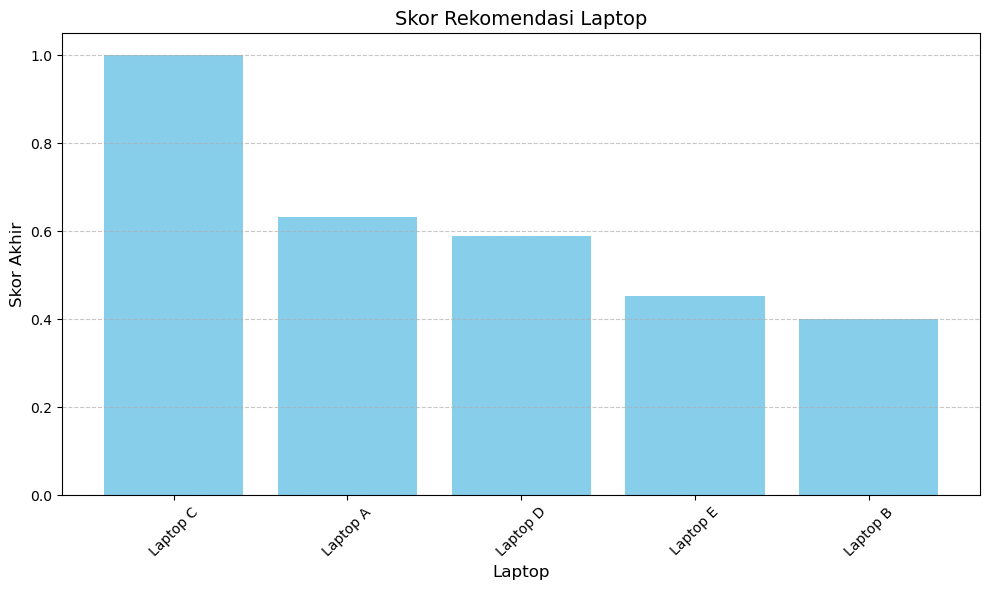

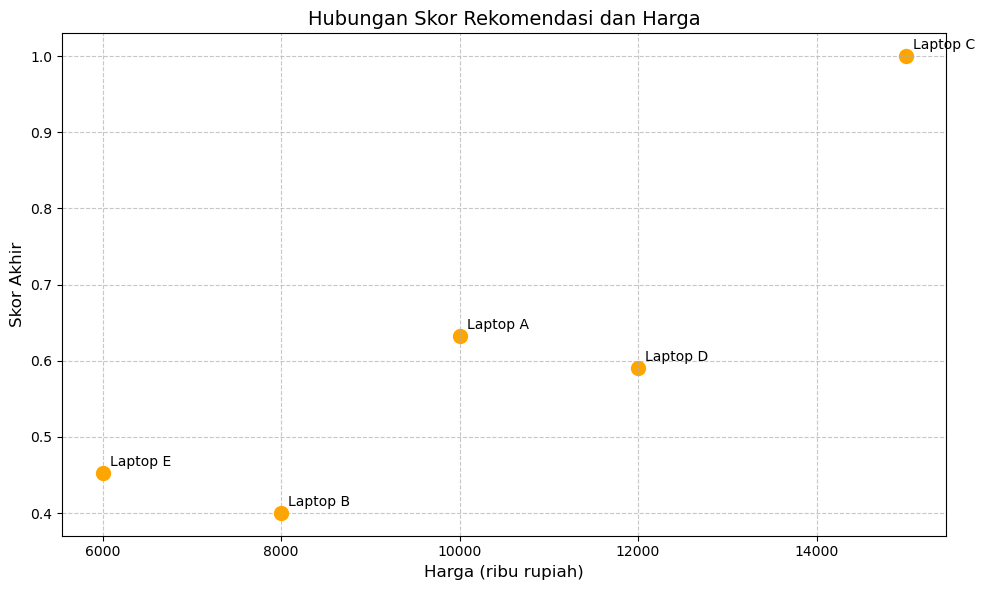

In [9]:
import matplotlib.pyplot as plt
# --- Tahap 6: Visualisasi Hasil Rekomendasi ---
print_step("Tahap 6: Visualisasi Hasil Rekomendasi", "Menampilkan visualisasi skor rekomendasi")

# Bar Chart untuk skor akhir
plt.figure(figsize=(10, 6))
plt.bar(laptops_sorted['Laptop'], laptops_sorted['Final_Score'], color='skyblue')
plt.title('Skor Rekomendasi Laptop', fontsize=14)
plt.xlabel('Laptop', fontsize=12)
plt.ylabel('Skor Akhir', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Scatter Plot: Skor vs Harga
plt.figure(figsize=(10, 6))
plt.scatter(laptops_sorted['Price'], laptops_sorted['Final_Score'], color='orange', s=100)
for i, txt in enumerate(laptops_sorted['Laptop']):
    plt.annotate(txt, (laptops_sorted['Price'].iloc[i], laptops_sorted['Final_Score'].iloc[i]), xytext=(5, 5), textcoords='offset points')
plt.title('Hubungan Skor Rekomendasi dan Harga', fontsize=14)
plt.xlabel('Harga (ribu rupiah)', fontsize=12)
plt.ylabel('Skor Akhir', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()